In [1]:
import json
import os
import pickle
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def loadData(filename, paperlimit):
    if (os.path.exists(filename+".p")):
        json_data = pickle.load( open( filename+".p", "rb" ) )
    else:
        data = "["
        with open(filename+".txt") as myfile:
            counter = 0 
            for line in myfile:
                counter += 1
                data += line + ","
                if counter > paperlimit:
                    break

        data = data[:-1] + "]"

        json_data = json.loads(data)
        pickle.dump( json_data, open( filename+".p", "wb" ) )

    return json_data

In [3]:
filename = "aminer_papers_0"
json_data = loadData(filename, 30000)
print("Loaded", filename, "as json")

Loaded aminer_papers_0 as json


In [4]:
paper_to_authors = dict()
paper_to_journal = dict()

for paper_obj in json_data:
    if 'id' in paper_obj and 'authors' in paper_obj and 'venue' in paper_obj:
        paper = paper_obj['id']
        authors = paper_obj['authors']
        journal = paper_obj['venue']
        
        paper_to_authors[paper] = [author['name'] for author in authors]
        paper_to_journal[paper] = journal
        
print("# papers: ", len(paper_to_authors))

# papers:  23965


In [5]:
author_to_author_and_papers = dict()

for paper_obj in json_data:
    if 'references' in paper_obj and 'authors' in paper_obj and 'venue' in paper_obj:
        paper_refs = paper_obj['references']
        author_and_papers = dict()
        for paper_ref in paper_refs:
            if paper_ref in paper_to_authors:
                authors = paper_to_authors[paper_ref]
                for author in authors:
                    if author not in author_and_papers:
                        author_and_papers[author] = [paper_ref]
                    else:
                        author_and_papers[author].append(paper_ref)
        for author in paper_obj['authors']:
            author_to_author_and_papers[author['name']] = author_and_papers

In [6]:
cleaned_author_to_etc = dict()

for obj in author_to_author_and_papers.keys():
    if author_to_author_and_papers[obj]:
        cleaned_author_to_etc[obj] = author_to_author_and_papers[obj]
        
print("# authors: ", len(author_to_author_and_papers))
        
defaultIF = 2
paper_to_if = {key:defaultIF for key in paper_to_journal.keys()}

selectJournal_to_if = {"Nature":40.137, "The Lancet":44.02, "British Medical Journal":20.785,
                       "Contemporary Medicine":0.1, "Reactions Weekly":0.1, "science":37.205, "Science":37.205,
                       "Journal of Clinical Nursing":1.214, "Methods in Enzymology":2.002,
                       "Scientific American":0.16, "American Journal of The Medical Sciences":1.195,
                      "Journal of the Franklin Institute":3.139, "Psyccritiques":0.01, "Astronomische Nachrichten":0.916,
                      "Lancet (London, England)":44.02, "American Journal of The Medical Sciences":1.195,
                      "British medical journal":20.785, "Science (New York, N.Y.)":37.205, "Phytochemistry":2.547,
                      "American Historical Review":1.145,"Classical Review":0.01,
                       "Annals of The American Academy of Political and Social Science":2.118,
                      "Journal of Chemical Education":1.419, "Deutsche Medizinische Wochenschrift":0.625,
                      "Journal of Nervous and Mental Disease":1.682, "Physics Today":4.188, "New Scientist":0.03,
                      "Science News":0.03, "Jama-journal of The American Medical Association": 44.405,
                       "Chinese Community Doctors":0.03, "Journal of Nurses Training":0.03,"Chinese Journal of Nursing":0.03,
                      "Langenbecks Archiv für Chirurgie":2.191,"New England Journal of Medicine":72.406,
                      "Laser & Optoelectronics Progress":0.03}

for selectJournal in selectJournal_to_if.keys():
    for paper, journal in paper_to_journal.items():
        if journal == selectJournal:
            paper_to_if[paper] = selectJournal_to_if[journal]

# authors:  6850


In [7]:
unique, counts = np.unique(list(paper_to_journal.values()), return_counts = True)
journal_occurences = dict(zip(unique, counts))
top_j = 30
top_j_journal_occ = sorted(journal_occurences, key=journal_occurences.get, reverse=True)[:top_j]

print("Top", top_j, "Frequent Journals")
for journal in top_j_journal_occ:
    print(journal, journal_occurences[journal])

Top 30 Frequent Journals
Nature 689
British Medical Journal 592
The Lancet 424
Contemporary Medicine 422
Reactions Weekly 241
science 231
Journal of Clinical Nursing 204
Methods in Enzymology 204
Scientific American 173
American Journal of The Medical Sciences 156
Science News 148
New Scientist 132
Jama-journal of The American Medical Association 131
Astronomische Nachrichten 130
Chinese Community Doctors 120
Science (New York, N.Y.) 120
Classical Review 118
Lancet (London, England) 115
Science & Technology Information 112
Physics Today 110
Journal of Nurses Training 105
Science 100
Deutsche Medizinische Wochenschrift 95
Journal of the Franklin Institute 88
Journal of The Acoustical Society of America 87
Psyccritiques 84
Langenbecks Archiv für Chirurgie 83
Laser & Optoelectronics Progress 83
New England Journal of Medicine 74
Chinese Journal of Nursing 73


In [8]:
#returns id of author chosen uniformly randomly
def randStartPoint(author_to_score):
    idx = np.random.randint(len(author_to_score))
    return list(author_to_score.keys())[idx]   #perhaps sorting issues here? check later

def getScore(cur_author, proposed_author, author_to_score):
    papers = author_to_author_and_papers[cur_author][proposed_author]
    score = 0
    for paper in papers:
        paper_authors = paper_to_authors[paper]
        avg_author_score = np.mean([author_to_score[auth] for auth in paper_authors if auth in author_to_score])
        score += avg_author_score * paper_to_if[paper]
    
    return np.log10(score)

def addToExplored(authors_explored, cur_author):
    if cur_author in authors_explored.keys():
        authors_explored[cur_author] += 1
    else:
        authors_explored[cur_author] = 0

In [9]:
def graphtraversal(num_trials, num_walks_per_trial):
    numAuthors = len(author_to_author_and_papers)
    
    for i in range(num_trials):
        authors_explored = {}
        deadend = 0
        p_accept_lt_1 = 0
        trial_output = np.zeros((numAuthors, num_walks_per_trial))
        
        startScore = 1
        author_to_score = collections.OrderedDict([(author, startScore) for author in author_to_author_and_papers.keys()])
        
        print("\nTrial number ", str(i+1), "/", num_trials)
    
        # Select uniform start point
        cur_author = randStartPoint(author_to_score)
        addToExplored(authors_explored, cur_author)
        
        for num_walk in range(num_walks_per_trial):
            if len(author_to_author_and_papers[cur_author]) == 0: #current author is a dead end
                cur_author = randStartPoint(author_to_score)
                addToExplored(authors_explored, cur_author)
                deadend += 1
            else:
                tries = 10
                for t in range(tries):
                    idx = np.random.randint(len(author_to_author_and_papers[cur_author]))
                    proposed_author = list(author_to_author_and_papers[cur_author].keys())[idx]
                    if proposed_author in author_to_score:
                        break
                if proposed_author not in author_to_score:
                    cur_author = randStartPoint(author_to_score)
                    addToExplored(authors_explored, cur_author)
                    continue

                # Accept with probability p_accept, according to Metropolis Hastings
                pi_y = author_to_score[proposed_author]  #pi(x) = score(x)
                pi_x = author_to_score[cur_author]
                
                # Proposal function f(x) = 1/d where d is degree of node x (number of outgoing edges)
                f_y = 1 / max(1, len(author_to_author_and_papers[proposed_author]))
                f_x = 1 / max(1, len(author_to_author_and_papers[cur_author]))
                
                p_accept = min(1, (pi_y * f_y) / (pi_x * f_x))
                if p_accept < 1:
                    p_accept_lt_1 += 1

                if proposed_author in author_to_score and np.random.random() < p_accept and proposed_author != cur_author:
                    #if accept, update proposed_author's score.  Then move to proposed_author
                    author_to_score[proposed_author] += getScore(cur_author, proposed_author, author_to_score)
                    cur_author = proposed_author
                    addToExplored(authors_explored, cur_author)
                    
                else:  #if not accept, randomly start again
                    cur_author = randStartPoint(author_to_score)
                    addToExplored(authors_explored, cur_author)
            trial_output[:, num_walk] = list(author_to_score.values())
        
        # Print summary statistics
        print("# authors explored: ", len(authors_explored))
        print("# of deadends: ", deadend, " | # of p_accept < 1: ", p_accept_lt_1)
        
        # Plot and display results
        top_x = 10
        top_authors = sorted(author_to_score, key=author_to_score.get, reverse=True)[:top_x]
        top_authors_idx = [list(author_to_score.keys()).index(author) for author in top_authors]
        print("Rank, # of visits, score, name:")
        for rank in range(top_x):
            print(rank+1, authors_explored[top_authors[rank]], author_to_score[top_authors[rank]], top_authors[rank])

        plt.figure(figsize=(14,7))
        rows, cols = trial_output.shape
        for row in top_authors_idx:
            y_data = trial_output[row]
            plt.plot(range(cols), y_data, '.', label=list(author_to_score.keys())[row])
        plt.xlabel("walk step")
        plt.ylabel("author score")
        plt.title("Evolution of author score through MCMC random walk")
        plt.legend()
        plt.savefig(filename+"_trial"+str(i+1)+".png")
     

Top 30 Frequent Journals
Nature 689
British Medical Journal 592
The Lancet 424
Contemporary Medicine 422
Reactions Weekly 241
science 231
Journal of Clinical Nursing 204
Methods in Enzymology 204
Scientific American 173
American Journal of The Medical Sciences 156
Science News 148
New Scientist 132
Jama-journal of The American Medical Association 131
Astronomische Nachrichten 130
Chinese Community Doctors 120
Science (New York, N.Y.) 120
Classical Review 118
Lancet (London, England) 115
Science & Technology Information 112
Physics Today 110
Journal of Nurses Training 105
Science 100
Deutsche Medizinische Wochenschrift 95
Journal of the Franklin Institute 88
Journal of The Acoustical Society of America 87
Psyccritiques 84
Langenbecks Archiv für Chirurgie 83
Laser & Optoelectronics Progress 83
New England Journal of Medicine 74
Chinese Journal of Nursing 73

# papers:  23965
# authors:  6850

Trial number  1 / 5
# authors explored:  6831
# of deadends:  35633  | # of p_accept < 1:  784
R

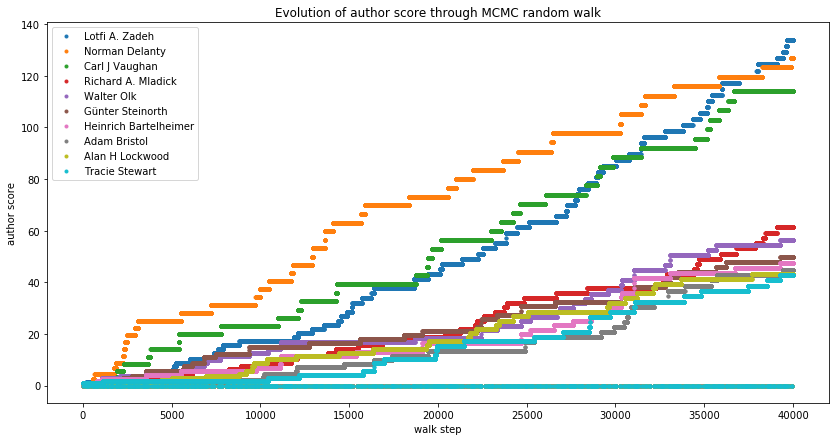

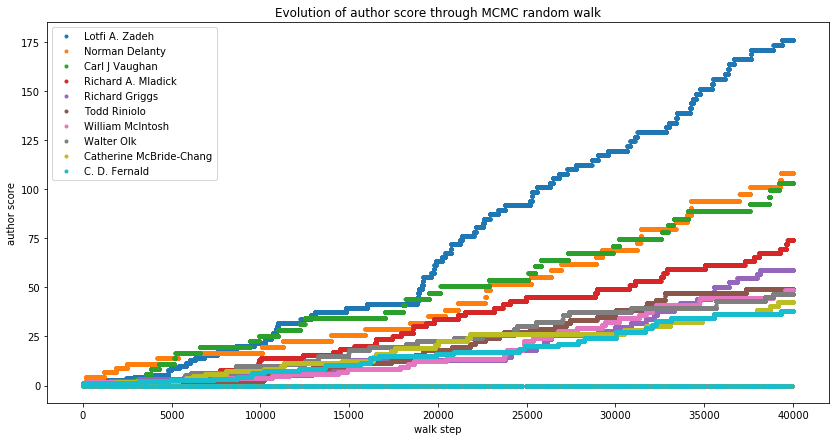

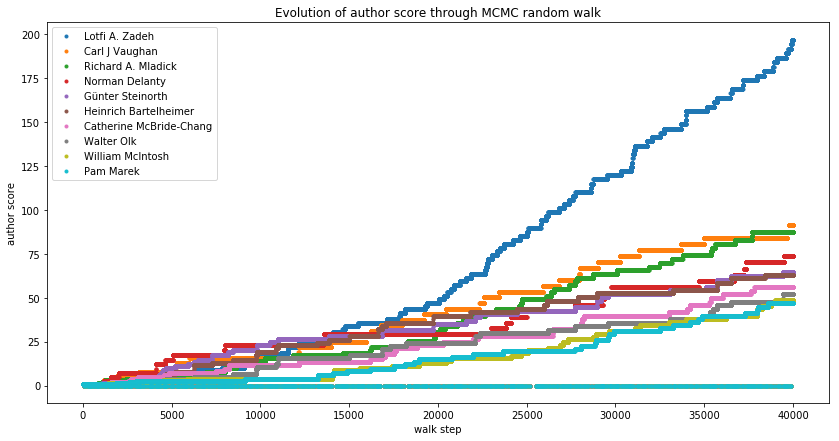

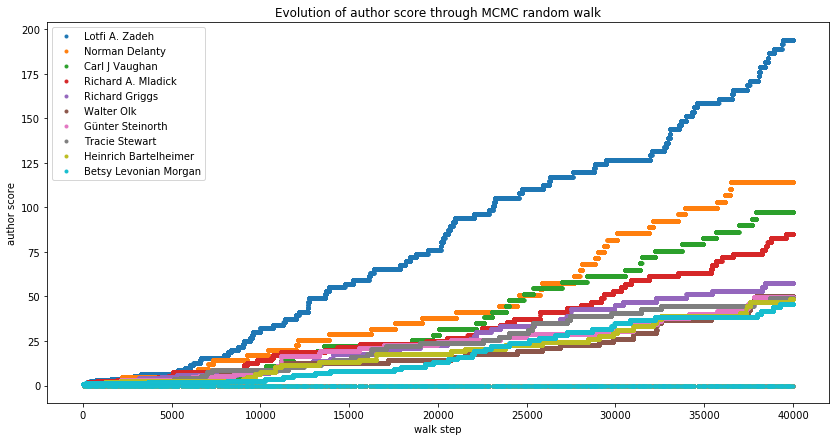

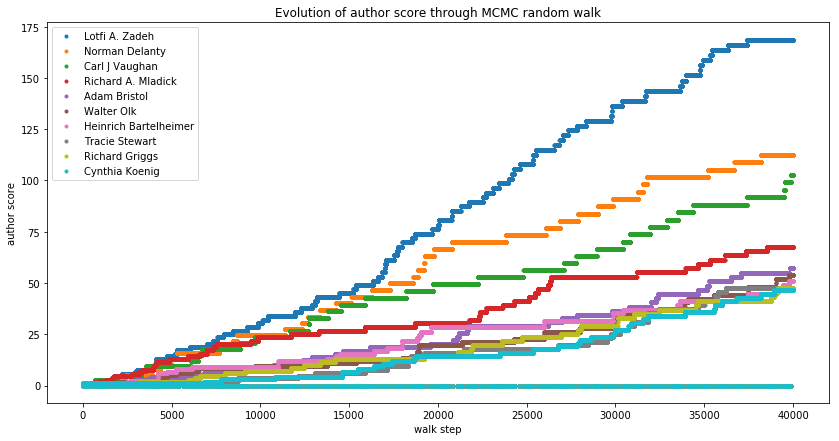

In [10]:
print("Top", top_j, "Frequent Journals")
for journal in top_j_journal_occ:
    print(journal, journal_occurences[journal])

print("\n# papers: ", len(paper_to_authors))
print("# authors: ", len(author_to_author_and_papers))

graphtraversal(5, 40000)